In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
from scipy.stats import multivariate_normal as mvn

from collections import defaultdict
from builtins import range, input

In [3]:

def get_data(limit=None):
    print("Reading in and transforming data...")
    df = pd.read_csv('../data/digit-recognizer/train.csv')
    data = df.values
    np.random.shuffle(data)
    X = data[:, 1:] / 255.0 # data is from 0..255
    Y = data[:, 0]
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

In [4]:
X, Y = get_data(10000)
Ntrain = len(Y) // 2
Xtrain, Ytrain = X[:Ntrain], Y[:Ntrain]
Xtest, Ytest = X[Ntrain:], Y[Ntrain:]


Reading in and transforming data...


In [5]:
X.shape
Y.shape

(10000, 784)

(10000,)

In [8]:
X[0].shape

(784,)

In [77]:
# We need the rows to be the Features, so either Transpose the X or make rowvar= False,
# so that it could Transpose internally
def getCovarianceMat(X, D, smoothing=1e-2):
    return np.cov(X.T) + np.eye(D)*smoothing

In [78]:

Ntrain
N, D = X.shape
X.shape
labels = set(Y)
labels

current_x = X[Y == 5]
current_x.shape
covmat = getCovarianceMat(current_x, D)
covmat.shape
#covmat2 = current_x.var(axis=0)
#covmat2.shape
mean = current_x.mean(axis=0)
print(f"mean shape {mean.shape}")

lgpdf = mvn.logpdf(current_x, mean=mean, cov=covmat)
lgpdf.shape
#lgpdf.reshape(lgpdf.shape[0], 1)
#np.argmax(lgpdf.reshape(lgpdf.shape[0], 1), axis=0)


arg = np.argmax(lgpdf, axis=0)
arg
lgpdf[arg]
lgpdf[arg-1]
lgpdf[arg+1]




#print(np.linalg.inv(covmat))




5000

(10000, 784)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

(909, 784)

(784, 784)

mean shape (784,)


(909,)

238

791.3283832695996

730.2054433076229

746.6334564455454

In [79]:

P = np.zeros((current_x.shape[0], 2))
P.shape

P[:,0] = lgpdf

lgpdf[arg+1] += lgpdf[arg] + 1

P[:,1] = lgpdf

(909, 2)

In [80]:
np.argmax(P[:,0] , axis=0)
np.argmax(P[:,1] , axis=0)
np.argmax(P , axis=0)

238

239

array([238, 239])

In [57]:
lgpdf[arg+1] += lgpdf[arg] + 1

In [58]:
arg = np.argmax(lgpdf, axis=0)
arg

432

In [48]:
lgpdf[arg]

792.8984245337365

Text(0.5, 1.0, '5')

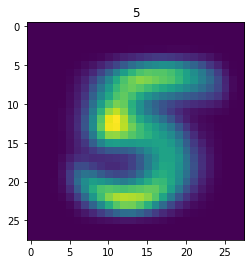

Text(0.5, 1.0, '5')

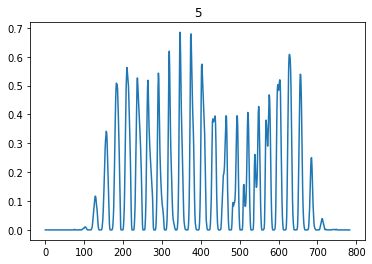

Text(0.5, 1.0, '5')

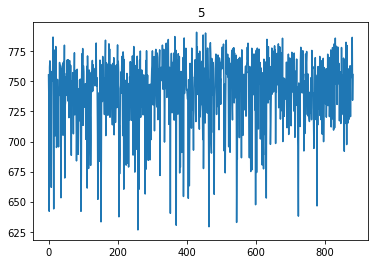

In [39]:

plt.imshow(mean.reshape(28, 28))
plt.title(5)
plt.show()

plt.plot(mean)
plt.title(5)
plt.show()


plt.plot(lgpdf)
plt.title(5)
plt.show()


In [85]:
class Bayes(object):
    def fit(self, X, Y, smoothing=1e-2):
        N, D = X.shape
        labels = set(Y)
        self.gaussians = np.array([defaultdict(float) for index in range(len(labels))])
        self.priors = dict()
        for c in labels:
            current_x = X[Y == c]
            self.gaussians[c] = {
                'mean': current_x.mean(axis=0),
                'var': getCovarianceMat(current_x, D, smoothing)
            }
            self.priors[c] = float(len(Y[Y == c])) / len(Y)

    def score(self, X, Y):
        P = self.predict(X)
        return np.mean(P == Y)

    def predict(self, X):
        N, D = X.shape
        K = len(labels)
        P = np.zeros((N, K))
        for c in labels:
            mean = self.gaussians[c]['mean']
            cov = self.gaussians[c]['var']
            logpdf = mvn.logpdf(X, mean=mean, cov=cov)
            prior = np.log(self.priors[c])
            P[:,c] = logpdf + np.log(self.priors[c])
            argmax = np.argmax(P, axis=1)
            print(f"c = {c}")
            print(f"logpdf = {logpdf}")
            print(f"prior = {prior}")
            print(f"P[:,c] = {P[:,c]}")
            print(f"argmax = {argmax}")
        return argmax

In [86]:

model = Bayes()
t0 = datetime.now()
model.fit(Xtrain, Ytrain)
print("Training time:", (datetime.now() - t0))

t0 = datetime.now()
print("Train accuracy:", model.score(Xtrain, Ytrain))
print("Time to compute train accuracy:", (datetime.now() - t0), "Train size:", len(Ytrain))

t0 = datetime.now()
print("Test accuracy:", model.score(Xtest, Ytest))
print("Time to compute test accuracy:", (datetime.now() - t0), "Test size:", len(Ytest))


Training time: 0:00:00.116351
c = 0
logpdf = [621.31111377 531.813566   353.02723587 ... 341.27988741 817.74592716
 809.03858628]
prior = -2.3475824589247813
P[:,c] = [618.96353131 529.46598354 350.67965342 ... 338.93230495 815.39834471
 806.69100382]
argmax = [0 0 0 ... 0 0 0]
c = 1
logpdf = [ -987.66836037 -1229.68754919   935.09104923 ... -1080.49251979
  -910.30133019 -1435.57023099]
prior = -2.209094749906707
P[:,c] = [ -989.87745512 -1231.89664394   932.88195448 ... -1082.70161454
  -912.51042494 -1437.77932574]
argmax = [0 0 1 ... 0 0 0]
c = 2
logpdf = [490.73307797 446.54148991 655.01076146 ... 695.83664539 535.58106316
 474.44820362]
prior = -2.3289290683336477
P[:,c] = [488.4041489  444.21256084 652.68183239 ... 693.50771633 533.2521341
 472.11927455]
argmax = [0 0 1 ... 2 0 0]
c = 3
logpdf = [694.91596297 658.2445851  675.56216248 ... 382.68380406 572.84975789
 434.07276879]
prior = -2.2576117273513145
P[:,c] = [692.65835125 655.98697338 673.30455075 ... 380.42619233 570.592

Text(0.5, 1.0, '0')

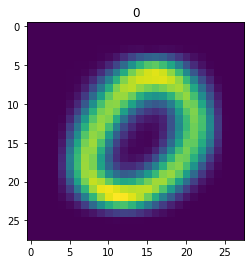

Text(0.5, 1.0, '1')

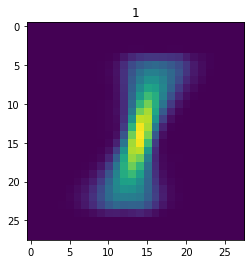

Text(0.5, 1.0, '2')

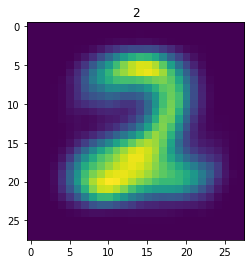

Text(0.5, 1.0, '3')

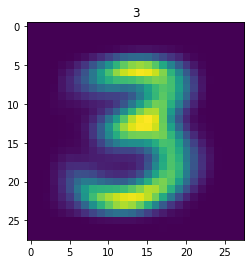

Text(0.5, 1.0, '4')

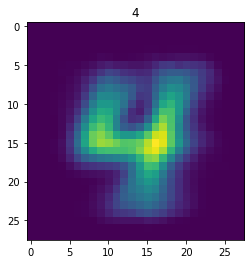

Text(0.5, 1.0, '5')

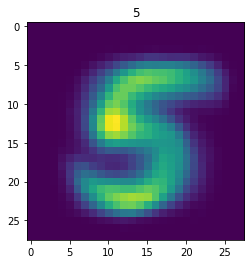

Text(0.5, 1.0, '6')

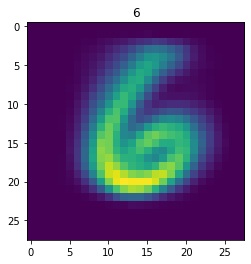

Text(0.5, 1.0, '7')

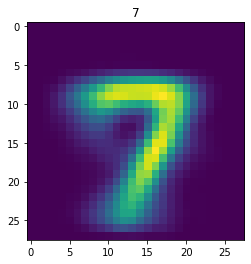

Text(0.5, 1.0, '8')

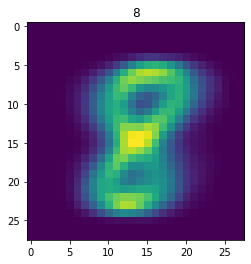

Text(0.5, 1.0, '9')

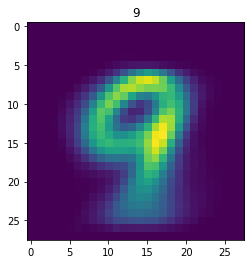

In [87]:

# plot the mean of each class
for c in labels:
    mean = model.gaussians[c]['mean']
    cov = model.gaussians[c]['var']
    #plt.plot(mean)
    #plt.title(c)
    #plt.show()
    plt.imshow(mean.reshape(28, 28))
    plt.title(c)
    plt.show()

In [52]:
gaussians = np.array([defaultdict(str) for index in range(4)])
#gaussians = defaultdict(str)

In [53]:
for c in range(4):
    gaussians[c] = {
        'mean': c,
        'cov': c*2,
    }

In [54]:
list(gaussians)

[{'mean': 0, 'cov': 0},
 {'mean': 1, 'cov': 2},
 {'mean': 2, 'cov': 4},
 {'mean': 3, 'cov': 6}]

In [55]:
for c in range(4):
    print(gaussians[c]['mean'])
    print(gaussians[c]['cov'])
    

0
0
1
2
2
4
3
6
